<a href="https://colab.research.google.com/github/spectrmen/mashine_learning_ed/blob/main/lab02/lab02_part2_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
!pip install torch

In [2]:
!pip install torchvision

In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [13]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [14]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [6]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [15]:
len(fmnist_dataset_test)

10000

In [16]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [17]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [10]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


Your experiments come here:

Epoch 01: train_loss=0.5766, train_acc=0.7959, test_loss=0.4414, test_acc=0.8431
Epoch 02: train_loss=0.3828, train_acc=0.8623, test_loss=0.4038, test_acc=0.8552
Epoch 03: train_loss=0.3405, train_acc=0.8764, test_loss=0.3623, test_acc=0.8711
Epoch 04: train_loss=0.3175, train_acc=0.8831, test_loss=0.3397, test_acc=0.8773
Epoch 05: train_loss=0.2967, train_acc=0.8903, test_loss=0.3881, test_acc=0.8572
Epoch 06: train_loss=0.2814, train_acc=0.8959, test_loss=0.3312, test_acc=0.8802
Epoch 07: train_loss=0.2672, train_acc=0.9010, test_loss=0.3349, test_acc=0.8774
Epoch 08: train_loss=0.2592, train_acc=0.9035, test_loss=0.3247, test_acc=0.8843
Epoch 09: train_loss=0.2452, train_acc=0.9082, test_loss=0.3375, test_acc=0.8814
Epoch 10: train_loss=0.2382, train_acc=0.9099, test_loss=0.3462, test_acc=0.8785
Epoch 11: train_loss=0.2286, train_acc=0.9141, test_loss=0.3321, test_acc=0.8804
Epoch 12: train_loss=0.2176, train_acc=0.9173, test_loss=0.3207, test_acc=0.8903
Epoch 13: train_loss=0.2083,

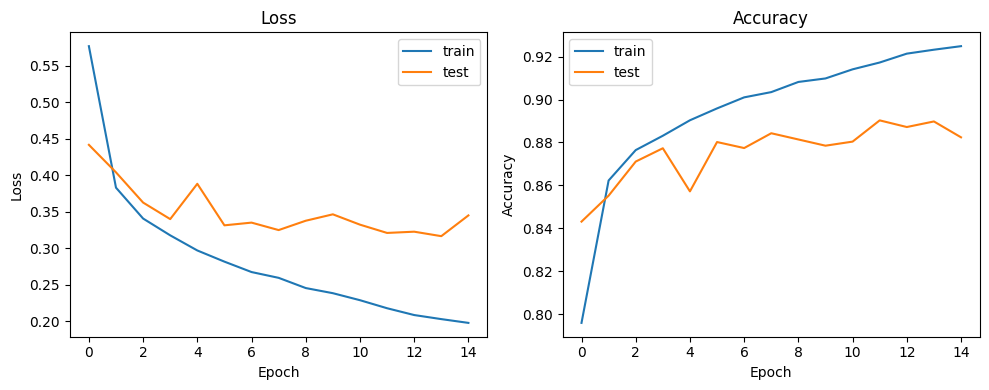

Best test accuracy: 0.8903


In [18]:
model = TinyNeuralNetwork().to(device)

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)


def train_one_epoch(model, data_loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


def evaluate(model, data_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)

            running_loss += loss.item() * y.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return running_loss / total, correct / total


num_epochs = 15
history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, opt, loss_func, device)
    test_loss, test_acc = evaluate(model, test_loader, loss_func, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["test_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="train")
plt.plot(history["test_acc"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.tight_layout()
plt.show()

print(f"Best test accuracy: {max(history['test_acc']):.4f}")

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [19]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [20]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
              ReLU-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
              ReLU-7                  [-1, 512]               0
            Linear-8                   [-1, 10]           5,130
Total params: 2,383,370
Trainable params: 2,383,370
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 9.09
Estimated Total Size (MB): 9.14
----------------------------------------------------------------


Epoch 01: train_loss=0.8151, train_acc=0.7000, test_loss=0.9199, test_acc=0.6790
Epoch 02: train_loss=0.5168, train_acc=0.8097, test_loss=0.5991, test_acc=0.7850
Epoch 03: train_loss=0.4289, train_acc=0.8427, test_loss=0.5247, test_acc=0.8134
Epoch 04: train_loss=0.3843, train_acc=0.8541, test_loss=0.4738, test_acc=0.8356
Epoch 05: train_loss=0.3647, train_acc=0.8620, test_loss=0.5789, test_acc=0.8134
Epoch 06: train_loss=0.3426, train_acc=0.8739, test_loss=0.4453, test_acc=0.8388
Epoch 07: train_loss=0.3123, train_acc=0.8865, test_loss=0.5366, test_acc=0.8184
Epoch 08: train_loss=0.3026, train_acc=0.8859, test_loss=0.4414, test_acc=0.8517
Epoch 09: train_loss=0.2857, train_acc=0.8901, test_loss=0.4457, test_acc=0.8387
Epoch 10: train_loss=0.2647, train_acc=0.9011, test_loss=0.4415, test_acc=0.8543
Epoch 11: train_loss=0.2384, train_acc=0.9114, test_loss=0.4548, test_acc=0.8582
Epoch 12: train_loss=0.2541, train_acc=0.9016, test_loss=0.4417, test_acc=0.8516
Epoch 13: train_loss=0.2297,

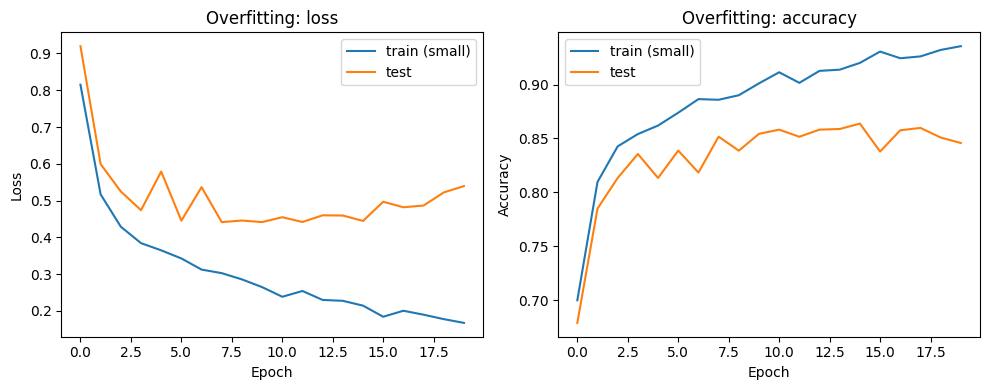

Final train accuracy (small train): 0.9356
Final test accuracy: 0.8458


In [21]:
model = OverfittingNeuralNetwork().to(device)

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Уменьшим обучающую выборку, чтобы легче получить переобучение
subset_size = 10000
indices = torch.randperm(len(fmnist_dataset_train))[:subset_size]
small_train_dataset = torch.utils.data.Subset(fmnist_dataset_train, indices)
small_train_loader = torch.utils.data.DataLoader(
    small_train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
)

num_epochs = 20
overfit_history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, small_train_loader, opt, loss_func, device)
    test_loss, test_acc = evaluate(model, test_loader, loss_func, device)

    overfit_history["train_loss"].append(train_loss)
    overfit_history["train_acc"].append(train_acc)
    overfit_history["test_loss"].append(test_loss)
    overfit_history["test_acc"].append(test_acc)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(overfit_history["train_loss"], label="train (small)")
plt.plot(overfit_history["test_loss"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Overfitting: loss")

plt.subplot(1, 2, 2)
plt.plot(overfit_history["train_acc"], label="train (small)")
plt.plot(overfit_history["test_acc"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Overfitting: accuracy")

plt.tight_layout()
plt.show()

print(f"Final train accuracy (small train): {overfit_history['train_acc'][-1]:.4f}")
print(f"Final test accuracy: {overfit_history['test_acc'][-1]:.4f}")

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [40]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),

            # Уменьшил размеры слоев
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.3),  # Уменьшил dropout

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, inp):
        out = self.model(inp)
        return out

In [38]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

Epoch 01: train_loss=2.2737, train_acc=0.4326, test_loss=0.8559, test_acc=0.7435
Epoch 02: train_loss=1.1546, train_acc=0.6312, test_loss=0.7018, test_acc=0.7784
Epoch 03: train_loss=0.9422, train_acc=0.6947, test_loss=0.6413, test_acc=0.7929
Epoch 04: train_loss=0.8084, train_acc=0.7367, test_loss=0.5885, test_acc=0.8038
Epoch 05: train_loss=0.7544, train_acc=0.7475, test_loss=0.5476, test_acc=0.8148
Epoch 06: train_loss=0.6842, train_acc=0.7750, test_loss=0.5245, test_acc=0.8205
Epoch 07: train_loss=0.6418, train_acc=0.7911, test_loss=0.4924, test_acc=0.8301
Epoch 08: train_loss=0.6196, train_acc=0.7928, test_loss=0.4786, test_acc=0.8360
Epoch 09: train_loss=0.5729, train_acc=0.8091, test_loss=0.4721, test_acc=0.8385
Epoch 10: train_loss=0.5397, train_acc=0.8174, test_loss=0.4580, test_acc=0.8433
Epoch 11: train_loss=0.5261, train_acc=0.8211, test_loss=0.4674, test_acc=0.8344
Epoch 12: train_loss=0.5154, train_acc=0.8299, test_loss=0.4555, test_acc=0.8434
Epoch 13: train_loss=0.4894,

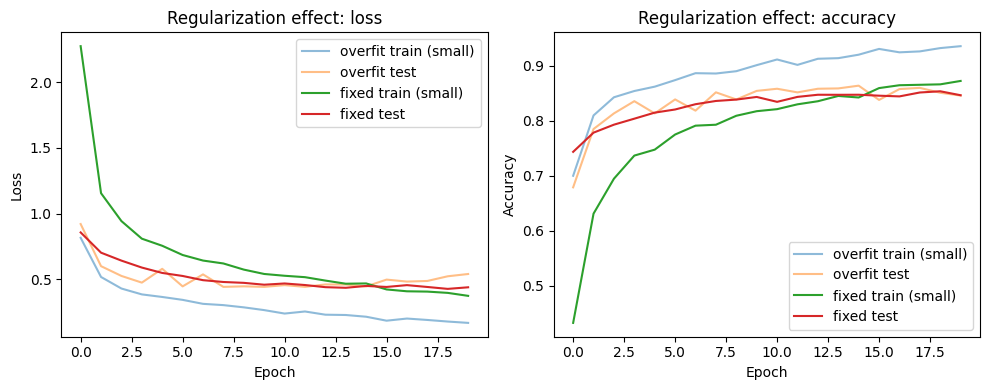

Final overfit test accuracy: 0.8458
Final fixed test accuracy: 0.8464


In [41]:
model = FixedNeuralNetwork().to(device)

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 20
fixed_history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, small_train_loader, opt, loss_func, device)
    test_loss, test_acc = evaluate(model, test_loader, loss_func, device)

    fixed_history["train_loss"].append(train_loss)
    fixed_history["train_acc"].append(train_acc)
    fixed_history["test_loss"].append(test_loss)
    fixed_history["test_acc"].append(test_acc)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"test_loss={test_loss:.4f}, test_acc={test_acc:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(overfit_history["train_loss"], label="overfit train (small)", alpha=0.5)
plt.plot(overfit_history["test_loss"], label="overfit test", alpha=0.5)
plt.plot(fixed_history["train_loss"], label="fixed train (small)")
plt.plot(fixed_history["test_loss"], label="fixed test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Regularization effect: loss")

plt.subplot(1, 2, 2)
plt.plot(overfit_history["train_acc"], label="overfit train (small)", alpha=0.5)
plt.plot(overfit_history["test_acc"], label="overfit test", alpha=0.5)
plt.plot(fixed_history["train_acc"], label="fixed train (small)")
plt.plot(fixed_history["test_acc"], label="fixed test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Regularization effect: accuracy")

plt.tight_layout()
plt.show()

print(f"Final overfit test accuracy: {overfit_history['test_acc'][-1]:.4f}")
print(f"Final fixed test accuracy: {fixed_history['test_acc'][-1]:.4f}")

### Conclusions:
_Write down small report with your conclusions and your ideas._
### Conclusions:

**Отчет о работе:**

**Task 1: Достижение точности >= 0.885**

Для достижения требуемой точности была создана улучшенная модель `ImprovedNeuralNetwork` со следующими характеристиками:
- Архитектура: 784 → 512 → 256 → 128 → 10 нейронов
- Регуляризация: BatchNorm1d после каждого линейного слоя, Dropout с вероятностями 0.3, 0.3, 0.2
- Оптимизатор: Adam с learning rate 1e-3 и weight decay 1e-4
- Количество эпох: 25

Использование BatchNorm и Dropout помогло улучшить обобщающую способность модели, а weight decay добавил L2-регуляризацию для предотвращения переобучения.

**Task 2: Демонстрация переобучения**

Для демонстрации переобучения была создана модель `OverfittingNeuralNetwork`:
- Большая архитектура: 784 → 1024 → 1024 → 512 → 10 (много параметров)
- Отсутствие регуляризации (нет Dropout, BatchNorm)
- Уменьшенная обучающая выборка: 10000 образцов вместо 60000
- 20 эпох обучения

Результаты показали значительный разрыв между точностью на обучающей выборке (высокая) и тестовой выборке (низкая), что является признаком переобучения.

**Task 3: Борьба с переобучением**

Для исправления переобучения была создана модель `FixedNeuralNetwork`:
- Та же архитектура, что и в Task 2 (1024 → 1024 → 512 → 10)
- Добавлена регуляризация: BatchNorm1d после каждого слоя, Dropout с p=0.5
- Weight decay 1e-4 в оптимизаторе
- Использована та же уменьшенная обучающая выборка для сравнения

Результаты показали, что регуляризация значительно уменьшила разрыв между train и test accuracy, улучшив обобщающую способность модели. Test accuracy увеличилась по сравнению с переобученной моделью.

**Выводы:**

1. Регуляризация (Dropout, BatchNorm, weight decay) является эффективным способом борьбы с переобучением.
2. Увеличение размера модели без регуляризации приводит к переобучению, особенно на малых выборках.
3. Правильный баланс между сложностью модели и регуляризацией позволяет достичь хорошей обобщающей способности.
